# Lesson 8: Time Series Forecasting

Please keep the TensorFlow version of this notebook as a reference: https://github.com/sambitmukherjee/handson-ml3/blob/main/bonus/udacity/Intro_to_TF_for_DL/Lesson_8_A.ipynb

In [1]:
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 824.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00


In [2]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00


If running this notebook in Colab, please ensure that your Hugging Face `HF_TOKEN` and your Weights & Biases `WANDB_API_KEY` are added to your Colab secrets.

Alternatively, please login to Hugging Face and Weights & Biases by running the following two cells.

In [3]:
# !huggingface-cli login

In [4]:
# !wandb login

In [5]:
import os
import random
import numpy as np
import torch

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

## I. Introduction

## II. Applications

## III. Common Patterns

## IV. Colab: Common Patterns

### Setup

In [6]:
import matplotlib.pyplot as plt

In [7]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label is not None:
        plt.legend(fontsize=14)
    plt.grid(True)

### Trend and Seasonality

In [8]:
def trend(time, slope=0):
    return slope * time

In [9]:
time = np.arange(4 * 365 + 1) # 1 is added since every four years there is a leap year.
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [10]:
baseline = 10
series = baseline + trend(time, 0.1)
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

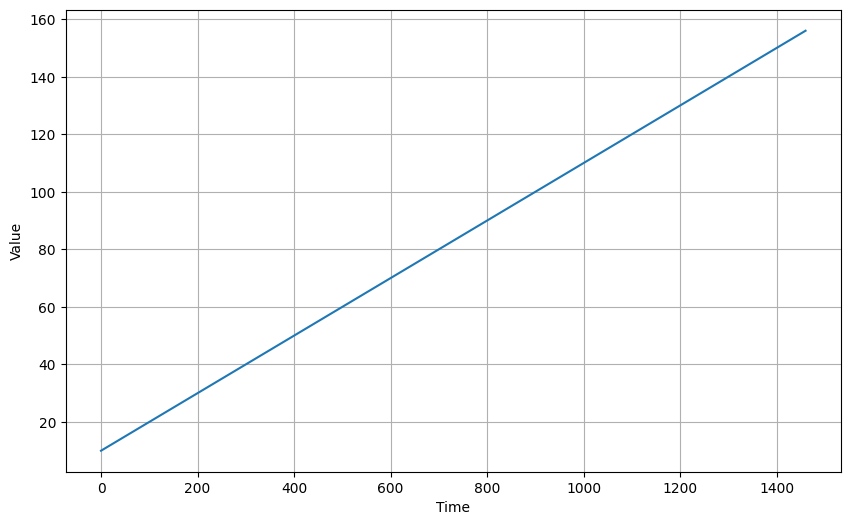

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [12]:
# Just run:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern; you can change it if you wish."""
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern in each period."""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

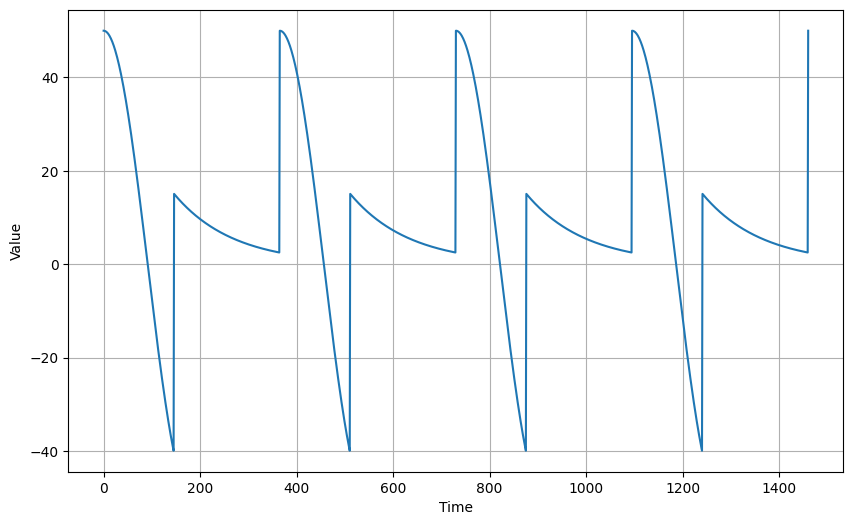

In [13]:
amplitude = 50
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

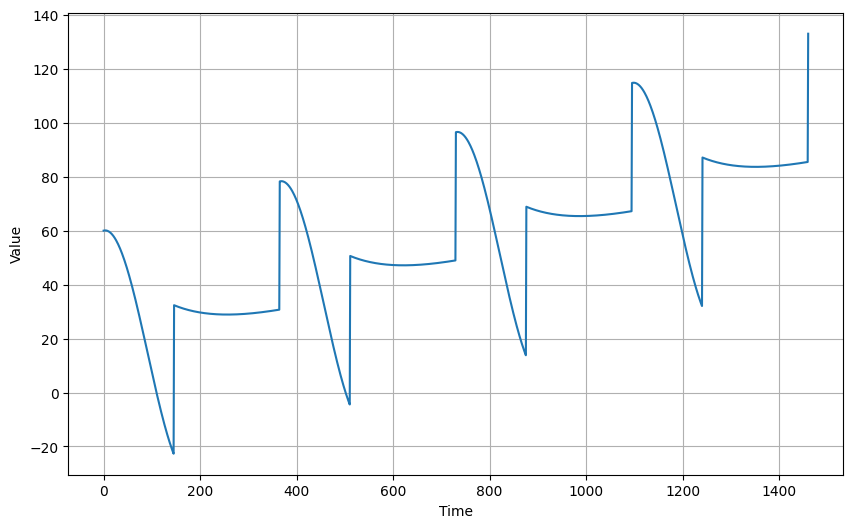

In [14]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

### Noise

In [15]:
def white_noise(time, noise_level=1, seed=None):
    return np.random.RandomState(seed).randn(len(time)) * noise_level

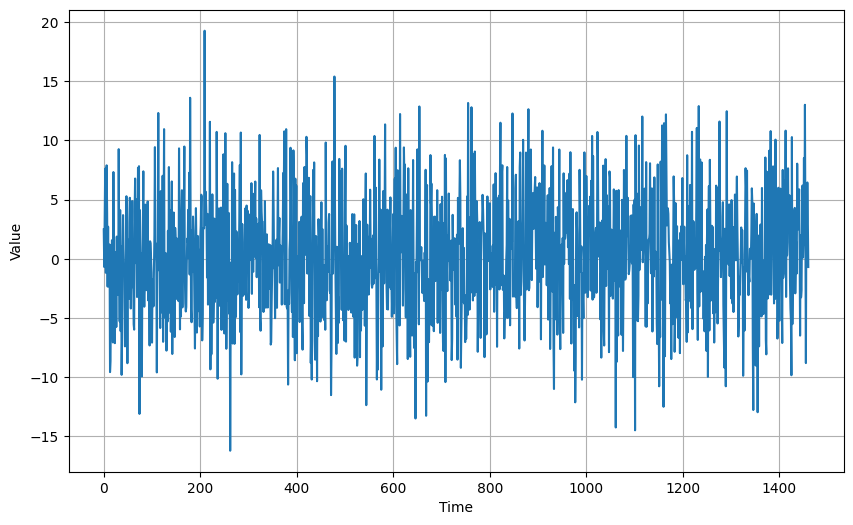

In [16]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

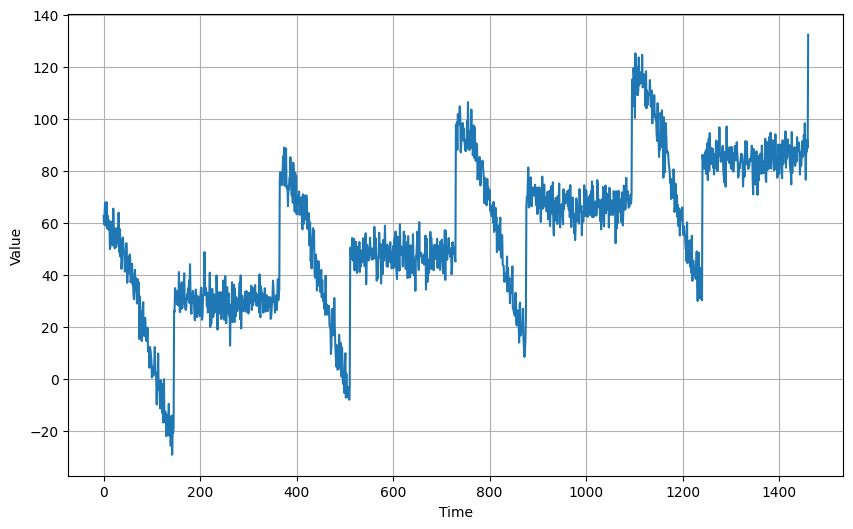

In [17]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

We shall call this the 'Geron Time Series' (named after Aurelien Geron).

## V. Naive Forecasting

## VI. Colab: Naive Forecasting

In [18]:
time.shape

(1461,)

In [19]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
time_train.shape, x_train.shape, time_valid.shape, x_valid.shape

((1000,), (1000,), (461,), (461,))

### Naive Forecast

In [20]:
naive_forecast = series[split_time - 1:-1]
naive_forecast.shape

(461,)

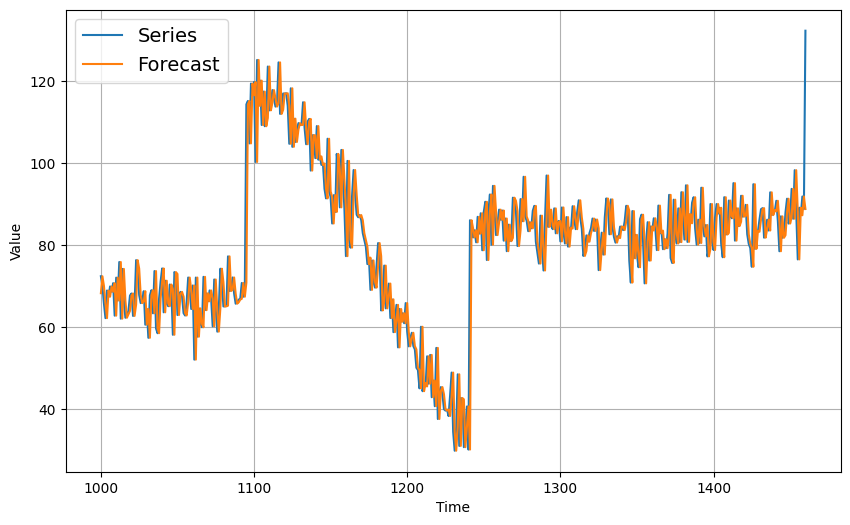

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, naive_forecast, label='Forecast')
plt.show()

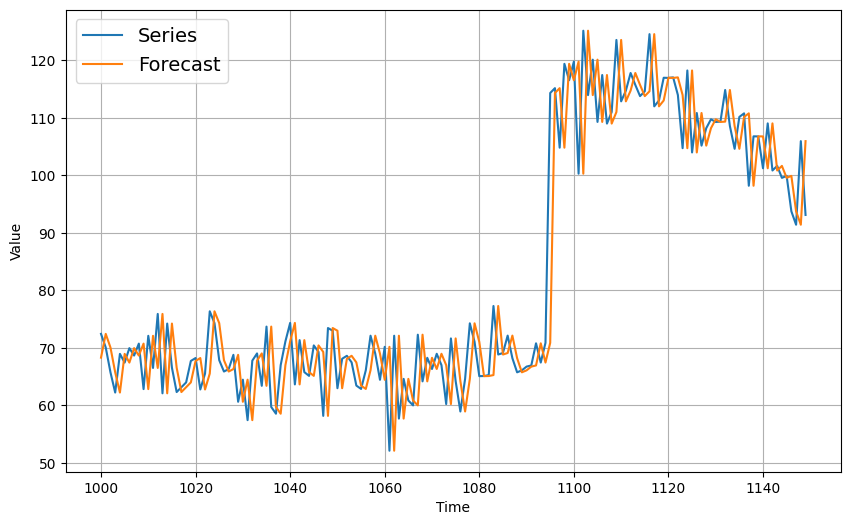

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label='Series')
plot_series(time_valid, naive_forecast, start=0, end=150, label='Forecast')
plt.show()

In [23]:
import evaluate

metric = evaluate.load("mae")

In [24]:
metric.compute(predictions=naive_forecast, references=x_valid)

{'mae': 6.0070818075647585}

## VII. Metrics, Moving Average & Differencing

SKIPPED

## VIII. Colab: Moving Average and Differencing

SKIPPED

## IX. Time Windows

In [25]:
x = torch.arange(10)
x

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [26]:
len(x)

10

In [27]:
# Exploratory:
window_size = 4
window_size += 1
for i in range(0, len(x) - window_size + 1, 1):
    print(x[i:i + window_size])

tensor([0, 1, 2, 3, 4])
tensor([1, 2, 3, 4, 5])
tensor([2, 3, 4, 5, 6])
tensor([3, 4, 5, 6, 7])
tensor([4, 5, 6, 7, 8])
tensor([5, 6, 7, 8, 9])


In [28]:
from torch.utils.data import Dataset, DataLoader

class WindowDataset(Dataset):
    def __init__(self, series, window_size):
        window_size += 1
        self.windows = []
        for i in range(0, len(series) - window_size + 1, 1):
            self.windows.append(series[i:i + window_size])

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]
        return window[:-1], window[-1]

In [29]:
x_ds = WindowDataset(x, window_size=4)
len(x_ds)

6

In [30]:
x_ds[0]

(tensor([0, 1, 2, 3]), tensor(4))

In [31]:
x_ds[-1]

(tensor([5, 6, 7, 8]), tensor(9))

In [32]:
x_dl = DataLoader(x_ds, batch_size=2, shuffle=True)
len(x_dl)

3

In [33]:
x_batch, y_batch = next(iter(x_dl))
print("x_batch =", x_batch)
print("y_batch =", y_batch)

x_batch = tensor([[4, 5, 6, 7],
        [5, 6, 7, 8]])
y_batch = tensor([8, 9])


In [34]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_train[:5]

tensor([62.4836, 59.3513, 63.3088, 67.6985, 58.9107])

In [35]:
x_valid = torch.tensor(x_valid, dtype=torch.float32)
x_valid[:5]

tensor([72.4317, 70.0636, 65.7445, 62.2179, 68.9503])

In [36]:
window_size = 30
train_set = WindowDataset(x_train, window_size)
valid_set = WindowDataset(x_valid, window_size)
len(train_set), len(valid_set)

(970, 431)

In [37]:
batch_size = 32
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
len(train_dl), len(valid_dl)

(31, 14)

In [38]:
# Sanity check:
x_batch, y_batch = next(iter(train_dl))
x_batch.shape, y_batch.shape

(torch.Size([32, 30]), torch.Size([32]))

In [39]:
# Sanity check:
x_batch, y_batch = next(iter(valid_dl))
x_batch.shape, y_batch.shape

(torch.Size([32, 30]), torch.Size([32]))

## X. Forecasting with Machine Learning

In [40]:
device = torch.device("cpu")
device

device(type='cpu')

### Linear Model

In [41]:
import torch.nn as nn
from huggingface_hub import PyTorchModelHubMixin

In [42]:
class LinearModel(nn.Module, PyTorchModelHubMixin):
    def __init__(self, window_size):
        super().__init__()
        self.linear = nn.Linear(window_size, 1)

    def forward(self, x):
        return self.linear(x)

In [43]:
model = LinearModel(window_size).to(device)
model

LinearModel(
  (linear): Linear(in_features=30, out_features=1, bias=True)
)

In [44]:
# Test:
x_batch = x_batch.to(device)
with torch.no_grad():
    preds = model(x_batch)
preds.shape

torch.Size([32, 1])

In [45]:
loss_fn = nn.HuberLoss(reduction='sum')

In [46]:
# Test:
y_batch = y_batch.to(device)
with torch.no_grad():
    loss = loss_fn(preds.squeeze(), y_batch)
loss

tensor(1449.0775)

In [47]:
from torch.optim import SGD

optimizer = SGD(model.parameters(), lr=1e-8, momentum=0.9)

In [48]:
from torch.optim.lr_scheduler import LambdaLR

lr_lambda = lambda epoch: 10**(epoch / 30)
lr_scheduler = LambdaLR(optimizer, lr_lambda)

From the documentation of <a href="https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html" target="_blank">LambdaLR</a>:

> Sets the learning rate of each parameter group to the initial `lr` times a given function.

- **lr_lambda** (*function* or *list*) - A function which computes a multiplicative factor given an integer parameter epoch, or a list of such functions, one for each group in `optimizer.param_groups`.

In Keras, the equivalent is:

```
lr_scheduler = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30)
)
```

In [49]:
def train_epoch():
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch)
        loss = loss_fn(preds.squeeze(), y_batch)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_set)
    train_loss = round(train_loss, 4)
    return train_loss

In [50]:
def validate_epoch():
    model.eval()
    valid_loss = 0
    metric = evaluate.load("mae")
    for x_batch, y_batch in valid_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        with torch.no_grad():
            preds = model(x_batch)
            loss = loss_fn(preds.squeeze(), y_batch)
        valid_loss += loss.item()
        metric.add_batch(predictions=preds.squeeze(), references=y_batch)
    valid_loss /= len(valid_set)
    valid_loss = round(valid_loss, 4)
    computed_metric = metric.compute()
    mae = round(computed_metric['mae'], 4)
    return valid_loss, mae

In [51]:
learning_rates = []
losses = []
for epoch in range(100):
    train_loss = train_epoch()
    losses.append(train_loss)
    learning_rates.append(lr_scheduler.get_last_lr())
    lr_scheduler.step()

In [52]:
len(learning_rates), len(losses)

(100, 100)

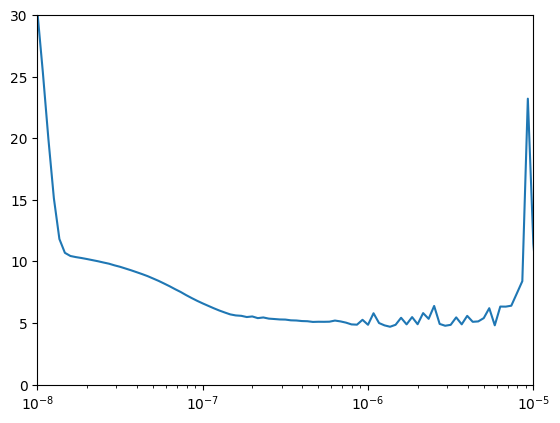

In [53]:
plt.semilogx(learning_rates, losses)
plt.axis([1e-8, 1e-5, 0, 30]);

A good learning rate is somewhere of the left of the unstable part. Let's pick `5e-7`.

In [54]:
model = LinearModel(window_size).to(device)
loss_fn = nn.HuberLoss(reduction='sum')
learning_rate = 5e-7
momentum = 0.9
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)
n_epochs = 500
patience = 10

In [55]:
import wandb

wandb_config = {
    'architecture': "Linear Regression",
    'dataset': "Geron Time Series",
    'window_size': window_size,
    'batch_size': batch_size,
    'loss_function': "Huber",
    'learning_rate': learning_rate,
    'momentum': momentum,
    'n_epochs': n_epochs,
    'patience': patience
}
wandb.init(
    project="linear-regression-geron-time-series",
    config=wandb_config,
    notes="Logging min of `train_loss`, `valid_loss`, and `mae`."
)
wandb.define_metric("train_loss", summary="min")
wandb.define_metric("valid_loss", summary="min")
wandb.define_metric("mae", summary="min")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [56]:
import math

best_epoch = 0
best_valid_loss = math.inf
early_stopping_counter = 0
for epoch in range(n_epochs):
    train_loss = train_epoch()

    valid_loss, mae = validate_epoch()

    print(f"Epoch: {epoch}, Training Loss: {train_loss}, Validation Loss: {valid_loss}, MAE: {mae}")
    print("---")

    wandb.log({'train_loss': train_loss, 'valid_loss': valid_loss, 'mae': mae})

    if valid_loss < best_valid_loss:
        best_epoch = epoch
        best_valid_loss = valid_loss
        model.push_to_hub("linear-regression-geron-time-series", commit_message=f"epoch: {epoch}, valid_loss: {valid_loss}")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f"No improvement for {patience} epochs. Stopping early at epoch {epoch}.")
        break
wandb.finish()
print("---")
print(f"Best Epoch: {best_epoch}, Best Validation Loss: {best_valid_loss}")

Epoch: 0, Training Loss: 13.5199, Validation Loss: 7.6933, MAE: 8.1777
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 1, Training Loss: 7.3725, Validation Loss: 7.3808, MAE: 7.8643
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 2, Training Loss: 6.1275, Validation Loss: 5.6842, MAE: 6.1634
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 3, Training Loss: 5.7305, Validation Loss: 5.7156, MAE: 6.1996
---
Epoch: 4, Training Loss: 5.5005, Validation Loss: 5.3555, MAE: 5.8358
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 5, Training Loss: 5.4234, Validation Loss: 5.5661, MAE: 6.0463
---
Epoch: 6, Training Loss: 5.3314, Validation Loss: 5.3239, MAE: 5.8033
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 7, Training Loss: 5.2294, Validation Loss: 5.29, MAE: 5.7657
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 8, Training Loss: 5.1624, Validation Loss: 5.3847, MAE: 5.8666
---
Epoch: 9, Training Loss: 5.3823, Validation Loss: 5.092, MAE: 5.5689
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 10, Training Loss: 5.187, Validation Loss: 5.189, MAE: 5.6628
---
Epoch: 11, Training Loss: 5.1198, Validation Loss: 5.7834, MAE: 6.2658
---
Epoch: 12, Training Loss: 5.1168, Validation Loss: 5.2938, MAE: 5.7718
---
Epoch: 13, Training Loss: 4.9848, Validation Loss: 5.4591, MAE: 5.9425
---
Epoch: 14, Training Loss: 4.9924, Validation Loss: 5.0204, MAE: 5.5012
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 15, Training Loss: 4.9448, Validation Loss: 6.2097, MAE: 6.6954
---
Epoch: 16, Training Loss: 4.9825, Validation Loss: 4.9685, MAE: 5.4493
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 17, Training Loss: 4.947, Validation Loss: 4.9085, MAE: 5.3867
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 18, Training Loss: 4.8642, Validation Loss: 5.0249, MAE: 5.4991
---
Epoch: 19, Training Loss: 4.8722, Validation Loss: 4.9156, MAE: 5.3994
---
Epoch: 20, Training Loss: 4.808, Validation Loss: 4.9647, MAE: 5.439
---
Epoch: 21, Training Loss: 4.7755, Validation Loss: 5.134, MAE: 5.6062
---
Epoch: 22, Training Loss: 4.8019, Validation Loss: 4.8228, MAE: 5.2968
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 23, Training Loss: 4.7437, Validation Loss: 4.7824, MAE: 5.2579
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 24, Training Loss: 4.7572, Validation Loss: 4.7911, MAE: 5.2736
---
Epoch: 25, Training Loss: 4.7536, Validation Loss: 4.7609, MAE: 5.2451
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 26, Training Loss: 4.8084, Validation Loss: 4.951, MAE: 5.4267
---
Epoch: 27, Training Loss: 4.7582, Validation Loss: 4.8061, MAE: 5.281
---
Epoch: 28, Training Loss: 4.7612, Validation Loss: 5.3033, MAE: 5.7891
---
Epoch: 29, Training Loss: 4.7242, Validation Loss: 4.7046, MAE: 5.1838
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 30, Training Loss: 4.7192, Validation Loss: 5.9174, MAE: 6.4029
---
Epoch: 31, Training Loss: 4.7064, Validation Loss: 4.9917, MAE: 5.4662
---
Epoch: 32, Training Loss: 4.6522, Validation Loss: 4.6987, MAE: 5.1792
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 33, Training Loss: 4.7094, Validation Loss: 5.462, MAE: 5.9445
---
Epoch: 34, Training Loss: 4.6762, Validation Loss: 4.6857, MAE: 5.1624
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 35, Training Loss: 4.6461, Validation Loss: 4.6784, MAE: 5.1569
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 36, Training Loss: 4.6893, Validation Loss: 4.8367, MAE: 5.3093
---
Epoch: 37, Training Loss: 4.6245, Validation Loss: 4.9448, MAE: 5.4212
---
Epoch: 38, Training Loss: 4.5972, Validation Loss: 4.646, MAE: 5.1265
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 39, Training Loss: 4.6168, Validation Loss: 4.6688, MAE: 5.1462
---
Epoch: 40, Training Loss: 4.661, Validation Loss: 4.8349, MAE: 5.309
---
Epoch: 41, Training Loss: 4.6271, Validation Loss: 4.6943, MAE: 5.1715
---
Epoch: 42, Training Loss: 4.6047, Validation Loss: 4.934, MAE: 5.4135
---
Epoch: 43, Training Loss: 4.5834, Validation Loss: 4.6653, MAE: 5.1423
---
Epoch: 44, Training Loss: 4.5975, Validation Loss: 5.3192, MAE: 5.8062
---
Epoch: 45, Training Loss: 4.5858, Validation Loss: 4.6176, MAE: 5.0973
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 46, Training Loss: 4.7625, Validation Loss: 5.0671, MAE: 5.5505
---
Epoch: 47, Training Loss: 4.5601, Validation Loss: 4.9035, MAE: 5.382
---
Epoch: 48, Training Loss: 4.7117, Validation Loss: 4.7371, MAE: 5.2075
---
Epoch: 49, Training Loss: 4.5491, Validation Loss: 4.6273, MAE: 5.1058
---
Epoch: 50, Training Loss: 4.5714, Validation Loss: 5.5075, MAE: 5.9871
---
Epoch: 51, Training Loss: 4.5853, Validation Loss: 4.5993, MAE: 5.0784
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 52, Training Loss: 4.6354, Validation Loss: 5.035, MAE: 5.5176
---
Epoch: 53, Training Loss: 4.5668, Validation Loss: 4.7025, MAE: 5.1764
---
Epoch: 54, Training Loss: 4.6212, Validation Loss: 4.7382, MAE: 5.2104
---
Epoch: 55, Training Loss: 4.5121, Validation Loss: 4.5893, MAE: 5.0685
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 56, Training Loss: 4.6447, Validation Loss: 6.1843, MAE: 6.6689
---
Epoch: 57, Training Loss: 4.6572, Validation Loss: 4.5877, MAE: 5.0668
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 58, Training Loss: 4.5797, Validation Loss: 4.6319, MAE: 5.1105
---
Epoch: 59, Training Loss: 4.5366, Validation Loss: 4.809, MAE: 5.2863
---
Epoch: 60, Training Loss: 4.5137, Validation Loss: 4.7087, MAE: 5.1822
---
Epoch: 61, Training Loss: 4.5215, Validation Loss: 4.6094, MAE: 5.0855
---
Epoch: 62, Training Loss: 4.5149, Validation Loss: 4.597, MAE: 5.0755
---
Epoch: 63, Training Loss: 4.7142, Validation Loss: 4.5847, MAE: 5.0644
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 64, Training Loss: 4.6282, Validation Loss: 6.0549, MAE: 6.5394
---
Epoch: 65, Training Loss: 4.6054, Validation Loss: 4.6853, MAE: 5.1578
---
Epoch: 66, Training Loss: 4.5165, Validation Loss: 4.589, MAE: 5.0683
---
Epoch: 67, Training Loss: 4.5589, Validation Loss: 4.5719, MAE: 5.0523
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 68, Training Loss: 4.4829, Validation Loss: 4.7439, MAE: 5.2198
---
Epoch: 69, Training Loss: 4.5105, Validation Loss: 4.7052, MAE: 5.1805
---
Epoch: 70, Training Loss: 4.5397, Validation Loss: 4.5703, MAE: 5.0514
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 71, Training Loss: 4.6391, Validation Loss: 4.9911, MAE: 5.4654
---
Epoch: 72, Training Loss: 4.5962, Validation Loss: 4.6683, MAE: 5.1452
---
Epoch: 73, Training Loss: 4.4862, Validation Loss: 4.6771, MAE: 5.1543
---
Epoch: 74, Training Loss: 4.4786, Validation Loss: 4.6547, MAE: 5.1292
---
Epoch: 75, Training Loss: 4.4849, Validation Loss: 4.5639, MAE: 5.0432
---


model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

Epoch: 76, Training Loss: 4.4992, Validation Loss: 5.0247, MAE: 5.5071
---
Epoch: 77, Training Loss: 4.5601, Validation Loss: 4.8953, MAE: 5.3685
---
Epoch: 78, Training Loss: 4.587, Validation Loss: 4.6002, MAE: 5.078
---
Epoch: 79, Training Loss: 4.4845, Validation Loss: 4.7511, MAE: 5.2267
---
Epoch: 80, Training Loss: 4.4485, Validation Loss: 5.8508, MAE: 6.3319
---
Epoch: 81, Training Loss: 4.7575, Validation Loss: 6.0554, MAE: 6.5385
---
Epoch: 82, Training Loss: 4.7038, Validation Loss: 6.9229, MAE: 7.415
---
Epoch: 83, Training Loss: 4.9023, Validation Loss: 5.6928, MAE: 6.17
---
Epoch: 84, Training Loss: 4.62, Validation Loss: 4.5948, MAE: 5.0729
---
Epoch: 85, Training Loss: 4.4771, Validation Loss: 4.5897, MAE: 5.0672
---
No improvement for 10 epochs. Stopping early at epoch 85.


mae,█▃▃▃▃▂▃▅▂▂▂▁▂▃▄▁▁▂▁▁▁▁▂▃▂▁▅▁▁▁▁▁▁▂▁▂▁▄▆▁
train_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▃▃▃▂▃▅▂▂▂▁▂▃▄▁▁▂▁▁▁▁▂▃▂▁▅▁▁▁▁▁▁▂▁▂▁▄▆▁


---
Best Epoch: 75, Best Validation Loss: 4.5639


In [57]:
model = LinearModel.from_pretrained("sadhaklal/linear-regression-geron-time-series")
model = model.to(device)
model.eval()

config.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268 [00:00<?, ?B/s]

LinearModel(
  (linear): Linear(in_features=30, out_features=1, bias=True)
)

In [58]:
def model_forecast(model, series):
    series = torch.tensor(series, dtype=torch.float32)
    ds = WindowDataset(series, window_size)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    forecast = []
    for x_batch, y_batch in dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        with torch.no_grad():
            preds = model(x_batch)
        forecast.append(preds.squeeze())
    forecast = torch.cat(forecast)
    return forecast.cpu().numpy()

In [59]:
linear_forecast = model_forecast(model, series[split_time - window_size:])
linear_forecast.shape

(461,)

**Note:** The last window contains x values for days `split_time - window_size` to `-2` (inclusive). And it contains the y value for day `-1`.

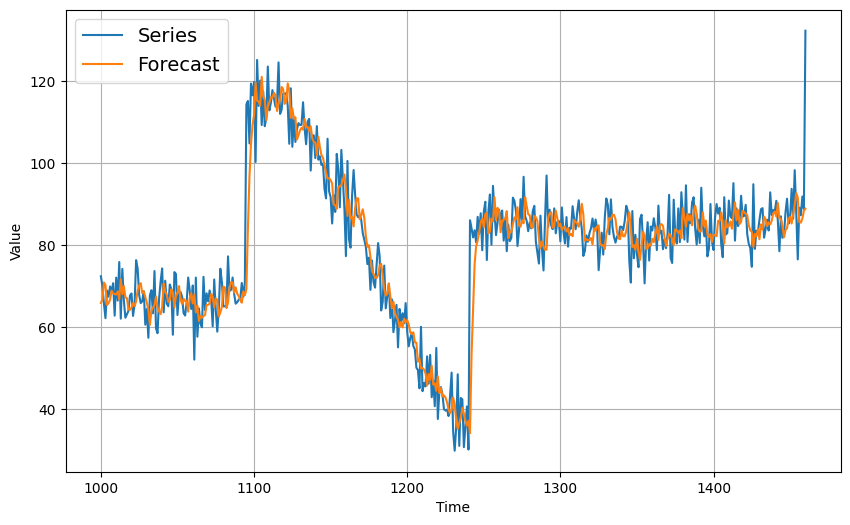

In [60]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, linear_forecast, label='Forecast')
plt.show()

In [61]:
metric.compute(predictions=linear_forecast, references=x_valid)

{'mae': 4.986850146874947}

### Dense Model Forecasting

In [62]:
class DenseModel(nn.Module, PyTorchModelHubMixin):
    def __init__(self, window_size):
        super().__init__()
        self.dense = nn.Sequential(
            nn.Linear(window_size, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.dense(x)

In [63]:
model = DenseModel(window_size).to(device)
model

DenseModel(
  (dense): Sequential(
    (0): Linear(in_features=30, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [64]:
# Test:
x_batch = x_batch.to(device)
with torch.no_grad():
    preds = model(x_batch)
preds.shape

torch.Size([32, 1])

In [65]:
loss_fn = nn.HuberLoss(reduction='sum')

In [66]:
# Test:
y_batch = y_batch.to(device)
with torch.no_grad():
    loss = loss_fn(preds.squeeze(), y_batch)
loss

tensor(2223.1919)

In [67]:
optimizer = SGD(model.parameters(), lr=1e-7, momentum=0.9)

In [68]:
lr_lambda = lambda epoch: 10**(epoch / 30)
lr_scheduler = LambdaLR(optimizer, lr_lambda)

In [69]:
learning_rates = []
losses = []
for epoch in range(100):
    train_loss = train_epoch()
    losses.append(train_loss)
    learning_rates.append(lr_scheduler.get_last_lr())
    lr_scheduler.step()

In [70]:
len(learning_rates), len(losses)

(100, 100)

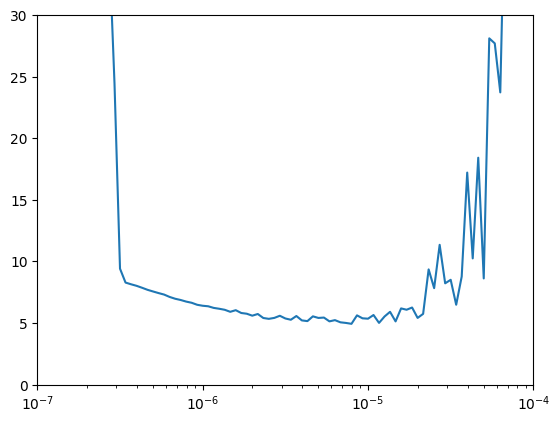

In [71]:
plt.semilogx(learning_rates, losses)
plt.axis([1e-7, 1e-4, 0, 30]);

A good learning rate is somewhere of the left of the unstable part. Let's pick `1e-6`.

In [72]:
model = DenseModel(window_size).to(device)
loss_fn = nn.HuberLoss(reduction='sum')
learning_rate = 1e-6
momentum = 0.9
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)
n_epochs = 500
patience = 10

In [73]:
wandb_config = {
    'architecture': "MLP",
    'dataset': "Geron Time Series",
    'window_size': window_size,
    'batch_size': batch_size,
    'loss_function': "Huber",
    'learning_rate': learning_rate,
    'momentum': momentum,
    'n_epochs': n_epochs,
    'patience': patience
}
wandb.init(
    project="mlp-geron-time-series",
    config=wandb_config,
    notes="Logging min of `train_loss`, `valid_loss`, and `mae`."
)
wandb.define_metric("train_loss", summary="min")
wandb.define_metric("valid_loss", summary="min")
wandb.define_metric("mae", summary="min")

wandb: Currently logged in as: sadhaklal. Use `wandb login --relogin` to force relogin


In [74]:
best_epoch = 0
best_valid_loss = math.inf
early_stopping_counter = 0
for epoch in range(n_epochs):
    train_loss = train_epoch()

    valid_loss, mae = validate_epoch()

    print(f"Epoch: {epoch}, Training Loss: {train_loss}, Validation Loss: {valid_loss}, MAE: {mae}")
    print("---")

    wandb.log({'train_loss': train_loss, 'valid_loss': valid_loss, 'mae': mae})

    if valid_loss < best_valid_loss:
        best_epoch = epoch
        best_valid_loss = valid_loss
        model.push_to_hub("mlp-geron-time-series", commit_message=f"epoch: {epoch}, valid_loss: {valid_loss}")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f"No improvement for {patience} epochs. Stopping early at epoch {epoch}.")
        break
wandb.finish()
print("---")
print(f"Best Epoch: {best_epoch}, Best Validation Loss: {best_valid_loss}")

Epoch: 0, Training Loss: 42.9522, Validation Loss: 64.4437, MAE: 64.9437
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 1, Training Loss: 21.7631, Validation Loss: 11.0154, MAE: 11.5093
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 2, Training Loss: 9.39, Validation Loss: 9.1422, MAE: 9.6308
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 3, Training Loss: 8.6856, Validation Loss: 8.146, MAE: 8.6294
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 4, Training Loss: 8.2495, Validation Loss: 8.7434, MAE: 9.2314
---
Epoch: 5, Training Loss: 7.8054, Validation Loss: 6.9631, MAE: 7.4399
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 6, Training Loss: 7.4014, Validation Loss: 7.0105, MAE: 7.4976
---
Epoch: 7, Training Loss: 7.1078, Validation Loss: 8.1544, MAE: 8.644
---
Epoch: 8, Training Loss: 6.8071, Validation Loss: 6.0733, MAE: 6.5532
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 9, Training Loss: 6.5638, Validation Loss: 6.559, MAE: 7.041
---
Epoch: 10, Training Loss: 6.369, Validation Loss: 7.4973, MAE: 7.9857
---
Epoch: 11, Training Loss: 6.366, Validation Loss: 5.8441, MAE: 6.3244
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 12, Training Loss: 6.219, Validation Loss: 5.6896, MAE: 6.1688
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 13, Training Loss: 6.0977, Validation Loss: 5.7167, MAE: 6.1983
---
Epoch: 14, Training Loss: 6.0058, Validation Loss: 5.4767, MAE: 5.9552
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 15, Training Loss: 5.9595, Validation Loss: 5.5527, MAE: 6.0348
---
Epoch: 16, Training Loss: 5.8632, Validation Loss: 5.3695, MAE: 5.8494
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 17, Training Loss: 5.8, Validation Loss: 5.3669, MAE: 5.8472
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 18, Training Loss: 5.7726, Validation Loss: 5.894, MAE: 6.3789
---
Epoch: 19, Training Loss: 5.731, Validation Loss: 5.4258, MAE: 5.9112
---
Epoch: 20, Training Loss: 5.6558, Validation Loss: 5.2121, MAE: 5.6857
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 21, Training Loss: 5.6099, Validation Loss: 5.4328, MAE: 5.9114
---
Epoch: 22, Training Loss: 5.5676, Validation Loss: 5.3227, MAE: 5.8075
---
Epoch: 23, Training Loss: 5.5227, Validation Loss: 5.2043, MAE: 5.6876
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 24, Training Loss: 5.4794, Validation Loss: 5.2017, MAE: 5.6838
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 25, Training Loss: 5.4141, Validation Loss: 5.1007, MAE: 5.5798
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 26, Training Loss: 5.3715, Validation Loss: 5.0742, MAE: 5.555
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 27, Training Loss: 5.3332, Validation Loss: 5.102, MAE: 5.5863
---
Epoch: 28, Training Loss: 5.3684, Validation Loss: 5.1215, MAE: 5.6044
---
Epoch: 29, Training Loss: 5.2698, Validation Loss: 5.1033, MAE: 5.5848
---
Epoch: 30, Training Loss: 5.2409, Validation Loss: 5.0639, MAE: 5.5461
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 31, Training Loss: 5.2557, Validation Loss: 5.0126, MAE: 5.4947
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 32, Training Loss: 5.1679, Validation Loss: 5.561, MAE: 6.0371
---
Epoch: 33, Training Loss: 5.1371, Validation Loss: 4.8784, MAE: 5.3517
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 34, Training Loss: 5.1621, Validation Loss: 6.5697, MAE: 7.0557
---
Epoch: 35, Training Loss: 5.2495, Validation Loss: 5.749, MAE: 6.225
---
Epoch: 36, Training Loss: 5.1352, Validation Loss: 4.8075, MAE: 5.2854
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 37, Training Loss: 4.9944, Validation Loss: 4.7879, MAE: 5.2645
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 38, Training Loss: 4.9723, Validation Loss: 4.7996, MAE: 5.2791
---
Epoch: 39, Training Loss: 4.9396, Validation Loss: 4.844, MAE: 5.3212
---
Epoch: 40, Training Loss: 5.0195, Validation Loss: 4.7734, MAE: 5.254
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 41, Training Loss: 4.9435, Validation Loss: 4.9168, MAE: 5.3918
---
Epoch: 42, Training Loss: 4.9723, Validation Loss: 5.2983, MAE: 5.777
---
Epoch: 43, Training Loss: 4.9534, Validation Loss: 5.369, MAE: 5.8479
---
Epoch: 44, Training Loss: 4.9023, Validation Loss: 4.8549, MAE: 5.3307
---
Epoch: 45, Training Loss: 4.9426, Validation Loss: 5.5011, MAE: 5.9763
---
Epoch: 46, Training Loss: 4.9098, Validation Loss: 4.7142, MAE: 5.1888
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 47, Training Loss: 4.8573, Validation Loss: 4.7092, MAE: 5.1839
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 48, Training Loss: 4.8885, Validation Loss: 4.8524, MAE: 5.324
---
Epoch: 49, Training Loss: 4.9391, Validation Loss: 4.8589, MAE: 5.3296
---
Epoch: 50, Training Loss: 4.8979, Validation Loss: 4.681, MAE: 5.1598
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 51, Training Loss: 4.9387, Validation Loss: 4.7373, MAE: 5.216
---
Epoch: 52, Training Loss: 5.134, Validation Loss: 5.1801, MAE: 5.6626
---
Epoch: 53, Training Loss: 4.8874, Validation Loss: 4.6769, MAE: 5.1495
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 54, Training Loss: 4.898, Validation Loss: 5.248, MAE: 5.7279
---
Epoch: 55, Training Loss: 4.873, Validation Loss: 4.6965, MAE: 5.1753
---
Epoch: 56, Training Loss: 4.8272, Validation Loss: 4.6643, MAE: 5.1457
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 57, Training Loss: 4.8024, Validation Loss: 4.7615, MAE: 5.2371
---
Epoch: 58, Training Loss: 4.7944, Validation Loss: 4.6836, MAE: 5.1662
---
Epoch: 59, Training Loss: 4.9239, Validation Loss: 4.6688, MAE: 5.1512
---
Epoch: 60, Training Loss: 4.8511, Validation Loss: 4.7127, MAE: 5.1921
---
Epoch: 61, Training Loss: 4.828, Validation Loss: 5.6708, MAE: 6.1478
---
Epoch: 62, Training Loss: 4.8477, Validation Loss: 4.7109, MAE: 5.1884
---
Epoch: 63, Training Loss: 4.8747, Validation Loss: 5.0493, MAE: 5.5268
---
Epoch: 64, Training Loss: 5.0248, Validation Loss: 4.6275, MAE: 5.1036
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 65, Training Loss: 4.791, Validation Loss: 4.625, MAE: 5.1018
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 66, Training Loss: 4.7713, Validation Loss: 4.6564, MAE: 5.1343
---
Epoch: 67, Training Loss: 4.8334, Validation Loss: 4.7883, MAE: 5.2622
---
Epoch: 68, Training Loss: 4.7969, Validation Loss: 4.7551, MAE: 5.2319
---
Epoch: 69, Training Loss: 4.7669, Validation Loss: 4.6176, MAE: 5.0904
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 70, Training Loss: 4.8132, Validation Loss: 4.68, MAE: 5.1593
---
Epoch: 71, Training Loss: 4.8389, Validation Loss: 4.918, MAE: 5.3927
---
Epoch: 72, Training Loss: 4.8949, Validation Loss: 4.9928, MAE: 5.4698
---
Epoch: 73, Training Loss: 4.7761, Validation Loss: 5.2543, MAE: 5.7292
---
Epoch: 74, Training Loss: 4.7493, Validation Loss: 4.667, MAE: 5.1465
---
Epoch: 75, Training Loss: 4.8707, Validation Loss: 4.7393, MAE: 5.217
---
Epoch: 76, Training Loss: 4.8026, Validation Loss: 4.6005, MAE: 5.0754
---


model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Epoch: 77, Training Loss: 4.7132, Validation Loss: 4.7582, MAE: 5.235
---
Epoch: 78, Training Loss: 4.7797, Validation Loss: 4.7051, MAE: 5.1856
---
Epoch: 79, Training Loss: 4.7689, Validation Loss: 5.0984, MAE: 5.5778
---
Epoch: 80, Training Loss: 4.7796, Validation Loss: 4.6123, MAE: 5.0874
---
Epoch: 81, Training Loss: 4.8328, Validation Loss: 4.759, MAE: 5.2353
---
Epoch: 82, Training Loss: 4.755, Validation Loss: 4.737, MAE: 5.2157
---
Epoch: 83, Training Loss: 4.7358, Validation Loss: 4.6479, MAE: 5.1283
---
Epoch: 84, Training Loss: 4.9191, Validation Loss: 5.931, MAE: 6.4176
---
Epoch: 85, Training Loss: 4.8074, Validation Loss: 4.9936, MAE: 5.471
---
Epoch: 86, Training Loss: 4.8373, Validation Loss: 4.607, MAE: 5.0834
---
No improvement for 10 epochs. Stopping early at epoch 86.


mae,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


---
Best Epoch: 76, Best Validation Loss: 4.6005


In [75]:
model = DenseModel.from_pretrained("sadhaklal/mlp-geron-time-series")
model = model.to(device)
model.eval()

config.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

DenseModel(
  (dense): Sequential(
    (0): Linear(in_features=30, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [76]:
dense_forecast = model_forecast(model, series[split_time - window_size:])
dense_forecast.shape

(461,)

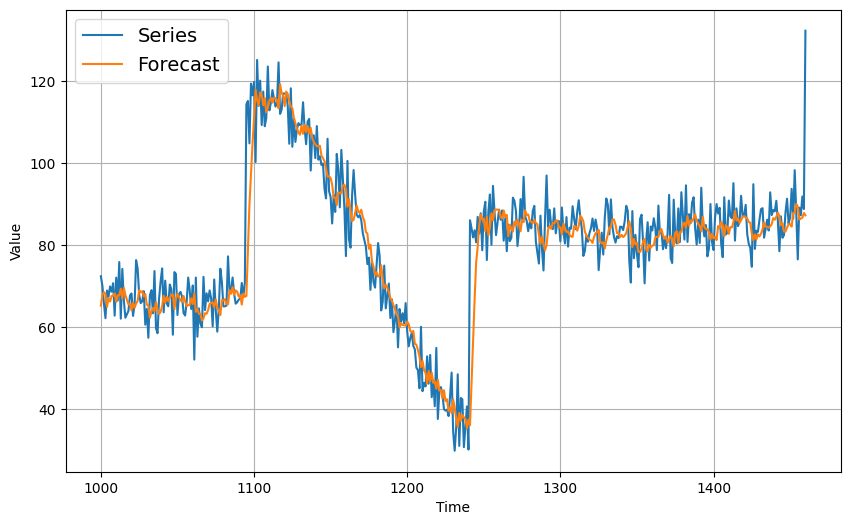

In [77]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, dense_forecast, label='Forecast')
plt.show()

In [78]:
metric.compute(predictions=dense_forecast, references=x_valid)

{'mae': 5.011922157767538}